# Modelo Xgboost

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from itertools import product

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# from common.utils import load_data, mape

# plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## FUNCIONES

In [3]:
import xgboost as xg

In [4]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def optimize_xgboost(parameters_list,data,variable_inte,criterio):
    """
        Return dataframe with parameters, corresponding MAPE and RMSE
        
        parameters_list - list with (timesteps,kernel, gamma,epsilon,C) tuples
        data - dataframe con la serie a modelar
        variable_inte = nombre de la columna que contiene la serie
        criterio = TOma el valor  de MAPE o RMSE
    """

    results = []
    
    for j in range(len(parameters_list)):
        try:
            
            scaler = MinMaxScaler()
            data[variable_inte] = scaler.fit_transform(pd.DataFrame(data[variable_inte].tolist()))
            train_data = data.values
            timesteps= parameters_list[j][0]
            train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
            
            x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
            
            model = xg.XGBRegressor(objective='reg:squarederror',n_estimators = parameters_list[j][1],
                        max_depth = parameters_list[j][2], 
                        learning_rate = parameters_list[j][3],
                        min_child_weight = parameters_list[j][4],seed=1234)
            
        
            
            model.fit(x_train, y_train[:,0])
            
            
            y_train_pred = model.predict(x_train).reshape(-1,1)
            y_train_pred = scaler.inverse_transform(y_train_pred)
            y_train = scaler.inverse_transform(y_train)
            
            mape = mean_absolute_percentage_error(y_train, y_train_pred)
            MAE = mean_absolute_error(y_train,y_train_pred)
            MSE = mean_squared_error(y_train, y_train_pred) 
            RMSE = math.sqrt(MSE)
            
        except:
            continue
            
        MAPE = round(mape*100,4)
        RMSE = round(RMSE,5)
        MAE = round(MAE,5)
        
        results.append([parameters_list[j][0],parameters_list[j][1],
                        parameters_list[j][2],parameters_list[j][3],
                        parameters_list[j][4],MAE,RMSE,mape])

    result_df = pd.DataFrame(results)
    result_df.columns = ['timesteps', 'n_estimators','max_depth','learning_rate','min_child_weight','RMSE','MAE','MAPE']
    result_df = result_df[result_df[criterio]==min(result_df[criterio])]
    
    return result_df



https://duchesnay.github.io/pystatsml/statistics/time_series.html

**Lectura de la MDT**

In [5]:
df_final = pd.read_csv('MDT_data_tesis_new.csv', sep = '|')
df_final = df_final.drop(columns = 'Unnamed: 0')
df_final.head()

,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log
0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579
1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571
2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480
3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488
4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972


## Variables globales

In [6]:
# steps = 330
variable_inte = 'variacion_log' # retorno logaritmicos lo que se llama retornos continuos
fecha_inicio_test = '2022-07-01'
#path_grafico = 'C:/Users/lifes/Documents/5. MAESTRIA CIENCIA DE DATOS/TRABAJO DE GRADO/Notebook Tesis/Graficos tesis python/'
path_grafico='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/graficos/'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["figure.edgecolor"] = "gray"
# variable_inte = 'variacion%'

In [43]:
df_final['nemotecnico'] = df_final['nemotecnico'].str.strip()
acciones=list(df_final['nemotecnico'].unique())
# acciones.remove('MSCI')

### Separacion base train-test

# Metodo XGboost

https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

**Optimización de Hiperparametros para el XGboost**

In [13]:
timesteps =[5,10] 
n_estimators=[100, 500, 900, 1500]
max_depth= [2, 5, 15]
learning_rate= [0.05, 0.1, 0.20]
min_child_weight= [1, 2, 3]


parameters = product(timesteps,n_estimators, max_depth,learning_rate,min_child_weight)
parameters_list = list(parameters)
print(len(parameters_list))

216


In [14]:
df_final['fecha'].head()

0    2019-10-02
1    2019-10-03
2    2019-10-04
3    2019-10-07
4    2019-10-08
Name: fecha, dtype: object

In [15]:
df_final.columns

Index(['nemotecnico', 'fecha', 'cantidad', 'volumen', 'precio_cierre',
       'precio_mayor', 'precio_medio', 'precio_menor', 'variacion%',
       'variacion_log'],
      dtype='object')

In [16]:
df_final[df_final['nemotecnico']=='BCOLOMBIA'].shape

(733, 10)

In [17]:
from datetime import datetime

current_dateTime = datetime.now()
current_dateTime

datetime.datetime(2023, 3, 29, 23, 39, 19, 586744)

In [18]:
inicio=datetime.now()

result_df_xgboost = pd.DataFrame(columns=['Acción', 'timesteps', 'n_estimators', 'max_depth','learning_rate',
                                          'min_child_weight','RMSE','MAE','MAPE'],
                             index=range(len(acciones)))

j=0
for i in acciones:
    
    df_interes = df_final[df_final['nemotecnico']==i]
    
    train = df_interes.copy()[(df_interes['fecha'] < fecha_inicio_test)]    
    train = train[[variable_inte]]

    result_xgb = optimize_xgboost(parameters_list, train,variable_inte,'MAE')

    result_df_xgboost.iloc[j][0] = i
    result_df_xgboost.iloc[j][1] = result_xgb.iloc[0,0]
    result_df_xgboost.iloc[j][2] = result_xgb.iloc[0,1]
    result_df_xgboost.iloc[j][3] = result_xgb.iloc[0,2]
    result_df_xgboost.iloc[j][4] = result_xgb.iloc[0,3]    
    result_df_xgboost.iloc[j][5] = result_xgb.iloc[0,4]
    result_df_xgboost.iloc[j][6] = result_xgb.iloc[0,5]
    result_df_xgboost.iloc[j][7] = result_xgb.iloc[0,6]

    j = j +1
    print(i)
    

result_df_xgboost.to_csv('parametro_xgboost.csv', sep='|')

final=datetime.now()

print(final-inicio)


BCOLOMBIA
BOGOTA
BVC
CELSIA
CEMARGOS
CLH
CNEC
CORFICOLCF
ECOPETROL
EXITO
GRUPOARGOS
GRUPOAVAL
GRUPOSURA
ISA
NUTRESA
PFAVAL
PFCEMARGOS
PFCORFICOL
PFDAVVNDA
PFGRUPOARG
PFGRUPSURA
1:24:29.442317


In [19]:
result_df_xgboost

,Acción,timesteps,n_estimators,max_depth,learning_rate,min_child_weight,RMSE,MAE,MAPE
0,BCOLOMBIA,10,100,15,0.2,1,0.0004,0.00062,NaN
1,BOGOTA,10,100,15,0.2,1,0.00038,0.00059,NaN
2,BVC,10,100,15,0.2,1,0.00053,0.00159,NaN
3,CELSIA,10,100,15,0.2,1,0.00042,0.00062,NaN
4,CEMARGOS,10,100,15,0.2,1,0.00044,0.00067,NaN
5,CLH,10,100,15,0.2,1,0.00158,0.01333,NaN
6,CNEC,10,100,15,0.2,2,0.00041,0.00065,NaN
7,CORFICOLCF,10,100,15,0.2,1,0.00044,0.00065,NaN
8,ECOPETROL,10,100,15,0.2,1,0.00039,0.0006,NaN
9,EXITO,10,100,15,0.2,1,0.00047,0.00114,NaN


In [26]:
result_df_xgboost=pd.read_csv('parametro_xgboost.csv', sep='|')
result_df_xgboost.drop(columns='Unnamed: 0',inplace=True)
result_df_xgboost.head()

,Acción,timesteps,n_estimators,max_depth,learning_rate,min_child_weight,RMSE,MAE,MAPE
0,BCOLOMBIA,10,100,15,0.2,1,0.00040,0.00062,NaN
1,BOGOTA,10,100,15,0.2,1,0.00038,0.00059,NaN
2,BVC,10,100,15,0.2,1,0.00053,0.00159,NaN
3,CELSIA,10,100,15,0.2,1,0.00042,0.00062,NaN
4,CEMARGOS,10,100,15,0.2,1,0.00044,0.00067,NaN


In [27]:
result_df_xgboost.head(50)

,Acción,timesteps,n_estimators,max_depth,learning_rate,min_child_weight,RMSE,MAE,MAPE
0,BCOLOMBIA,10,100,15,0.20,1,0.00040,0.00062,NaN
1,BOGOTA,10,100,15,0.20,1,0.00038,0.00059,NaN
2,BVC,10,100,15,0.20,1,0.00053,0.00159,NaN
3,CELSIA,10,100,15,0.20,1,0.00042,0.00062,NaN
4,CEMARGOS,10,100,15,0.20,1,0.00044,0.00067,NaN
5,CLH,10,100,15,0.20,1,0.00158,0.01333,NaN
6,CNEC,10,100,15,0.20,2,0.00041,0.00065,NaN
7,CORFICOLCF,10,100,15,0.20,1,0.00044,0.00065,NaN
8,ECOPETROL,10,100,15,0.20,1,0.00039,0.00060,NaN
9,EXITO,10,100,15,0.20,1,0.00047,0.00114,NaN


In [35]:
result_df_xgboost.Acción.unique()

array(['BCOLOMBIA', 'BOGOTA', 'BVC', 'CELSIA', 'CEMARGOS', 'CLH', 'CNEC',
       'CORFICOLCF', 'ECOPETROL', 'EXITO', 'GRUPOARGOS', 'GRUPOAVAL',
       'GRUPOSURA', 'ISA', 'NUTRESA', 'PFAVAL', 'PFCEMARGOS',
       'PFCORFICOL', 'PFDAVVNDA', 'PFGRUPOARG', 'PFGRUPSURA'],
      dtype=object)

### Estimacion con el modelo xgboost optimizado - Test

In [28]:
acciones

'PFDAVVNDA'

In [29]:
# Función de predicción
def agregarNuevoValor(x_test,newVal):
    arr=[]
    for i in x_test[0][0][1:x_test.shape[2]]:
        arr.append(i)
    arr.append(newVal[0][0])
    arr=pd.DataFrame(arr).values
    arr=np.array([arr])
    arr=arr.reshape((arr.shape[0], 1, arr.shape[1]))
    x_test=arr
    return x_test


In [30]:
len(range(733,733 + 90))

90

In [31]:
import pickle

In [32]:
fecha_inicio_test

'2022-07-01'

In [34]:
parmetros_optimos

,Acción,timesteps,n_estimators,max_depth,learning_rate,min_child_weight,RMSE,MAE,MAPE


In [44]:
acciones

['BCOLOMBIA',
 'BOGOTA',
 'BVC',
 'CELSIA',
 'CEMARGOS',
 'CLH',
 'CNEC',
 'CORFICOLCF',
 'ECOPETROL',
 'EXITO',
 'GRUPOARGOS',
 'GRUPOAVAL',
 'GRUPOSURA',
 'ISA',
 'NUTRESA',
 'PFAVAL',
 'PFCEMARGOS',
 'PFCORFICOL',
 'PFDAVVNDA',
 'PFGRUPOARG',
 'PFGRUPSURA']

10BCOLOMBIA
[[0.54650666 0.81937266 0.73594731 0.18003254 0.08379143 0.87478821
  0.46914965 0.60325672 0.39459586]]
[[0.81937266 0.73594731 0.18003254 0.08379143 0.87478821 0.46914965
  0.60325672 0.39459586 0.3419978 ]]
[[0.73594731 0.18003254 0.08379143 0.87478821 0.46914965 0.60325672
  0.39459586 0.3419978  0.34520474]]
[[0.18003254 0.08379143 0.87478821 0.46914965 0.60325672 0.39459586
  0.3419978  0.34520474 0.30973056]]
[[0.08379143 0.87478821 0.46914965 0.60325672 0.39459586 0.3419978
  0.34520474 0.30973056 0.48919505]]
[[0.87478821 0.46914965 0.60325672 0.39459586 0.3419978  0.34520474
  0.30973056 0.48919505 0.49203974]]
[[0.46914965 0.60325672 0.39459586 0.3419978  0.34520474 0.30973056
  0.48919505 0.49203974 0.4036254 ]]
[[0.60325672 0.39459586 0.3419978  0.34520474 0.30973056 0.48919505
  0.49203974 0.4036254  0.4495706 ]]
[[0.39459586 0.3419978  0.34520474 0.30973056 0.48919505 0.49203974
  0.4036254  0.4495706  0.44392988]]
[[0.3419978  0.34520474 0.30973056 0.4891950

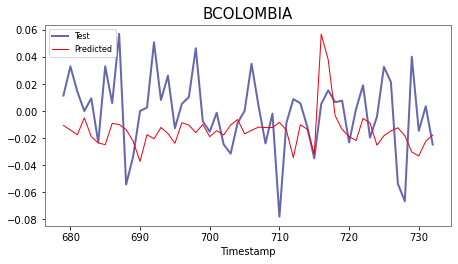

10BOGOTA
[[0.56169983 0.33999334 0.56548597 0.30930915 0.         0.43701677
  0.73842608 0.44243741 0.63066171]]
[[0.33999334 0.56548597 0.30930915 0.         0.43701677 0.73842608
  0.44243741 0.63066171 0.65383089]]
[[0.56548597 0.30930915 0.         0.43701677 0.73842608 0.44243741
  0.63066171 0.65383089 0.63015455]]
[[0.30930915 0.         0.43701677 0.73842608 0.44243741 0.63066171
  0.65383089 0.63015455 0.77730256]]
[[0.         0.43701677 0.73842608 0.44243741 0.63066171 0.65383089
  0.63015455 0.77730256 0.66478592]]
[[0.43701677 0.73842608 0.44243741 0.63066171 0.65383089 0.63015455
  0.77730256 0.66478592 0.73391253]]
[[0.73842608 0.44243741 0.63066171 0.65383089 0.63015455 0.77730256
  0.66478592 0.73391253 0.71809787]]
[[0.44243741 0.63066171 0.65383089 0.63015455 0.77730256 0.66478592
  0.73391253 0.71809787 0.67242557]]
[[0.63066171 0.65383089 0.63015455 0.77730256 0.66478592 0.73391253
  0.71809787 0.67242557 0.71460909]]
[[0.65383089 0.63015455 0.77730256 0.66478592 

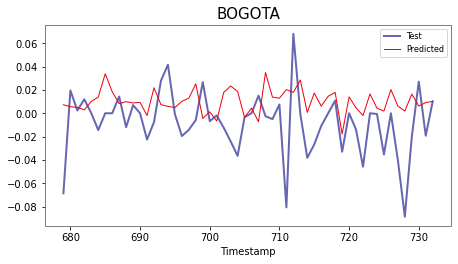

10BVC
[[0.61437307 0.53922035 0.63053457 0.57661384 0.63597079 0.61976373
  0.61437307 0.61976023 0.61437307]]
[[0.53922035 0.63053457 0.57661384 0.63597079 0.61976373 0.61437307
  0.61976023 0.61437307 0.58213001]]
[[0.63053457 0.57661384 0.63597079 0.61976373 0.61437307 0.61976023
  0.61437307 0.58213001 0.61659151]]
[[0.57661384 0.63597079 0.61976373 0.61437307 0.61976023 0.61437307
  0.58213001 0.61659151 0.58321583]]
[[0.63597079 0.61976373 0.61437307 0.61976023 0.61437307 0.58213001
  0.61659151 0.58321583 0.62218231]]
[[0.61976373 0.61437307 0.61976023 0.61437307 0.58213001 0.61659151
  0.58321583 0.62218231 0.61007488]]
[[0.61437307 0.61976023 0.61437307 0.58213001 0.61659151 0.58321583
  0.62218231 0.61007488 0.60401523]]
[[0.61976023 0.61437307 0.58213001 0.61659151 0.58321583 0.62218231
  0.61007488 0.60401523 0.61068702]]
[[0.61437307 0.58213001 0.61659151 0.58321583 0.62218231 0.61007488
  0.60401523 0.61068702 0.60567069]]
[[0.58213001 0.61659151 0.58321583 0.62218231 0.6

[[0.68511778 0.45528916 0.39143088 0.47501433 0.6093061  0.55292296
  0.49235752 0.56086445 0.52077365]]
[[0.45528916 0.39143088 0.47501433 0.6093061  0.55292296 0.49235752
  0.56086445 0.52077365 0.45816052]]
54
54


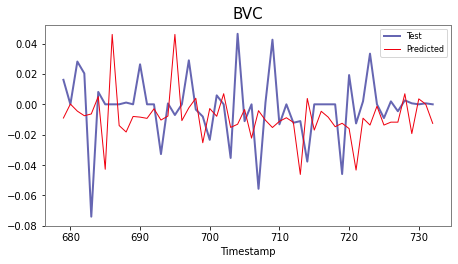

10CELSIA
[[0.79313714 0.65400902 0.67829882 0.65387133 0.41146123 0.78406873
  0.51848923 0.66521009 0.6703143 ]]
[[0.65400902 0.67829882 0.65387133 0.41146123 0.78406873 0.51848923
  0.66521009 0.6703143  0.63550156]]
[[0.67829882 0.65387133 0.41146123 0.78406873 0.51848923 0.66521009
  0.6703143  0.63550156 0.58379608]]
[[0.65387133 0.41146123 0.78406873 0.51848923 0.66521009 0.6703143
  0.63550156 0.58379608 0.58782005]]
[[0.41146123 0.78406873 0.51848923 0.66521009 0.6703143  0.63550156
  0.58379608 0.58782005 0.6579513 ]]
[[0.78406873 0.51848923 0.66521009 0.6703143  0.63550156 0.58379608
  0.58782005 0.6579513  0.55838364]]
[[0.51848923 0.66521009 0.6703143  0.63550156 0.58379608 0.58782005
  0.6579513  0.55838364 0.54336745]]
[[0.66521009 0.6703143  0.63550156 0.58379608 0.58782005 0.6579513
  0.55838364 0.54336745 0.60138279]]
[[0.6703143  0.63550156 0.58379608 0.58782005 0.6579513  0.55838364
  0.54336745 0.60138279 0.58326948]]
[[0.63550156 0.58379608 0.58782005 0.6579513  0.

[[0.61607218 0.59489721 0.57419151 0.60685009 0.60650128 0.6113596
  0.58778155 0.58459228 0.61172265]]
[[0.59489721 0.57419151 0.60685009 0.60650128 0.6113596  0.58778155
  0.58459228 0.61172265 0.60113317]]
[[0.57419151 0.60685009 0.60650128 0.6113596  0.58778155 0.58459228
  0.61172265 0.60113317 0.60078365]]
[[0.60685009 0.60650128 0.6113596  0.58778155 0.58459228 0.61172265
  0.60113317 0.60078365 0.60319364]]
54
54


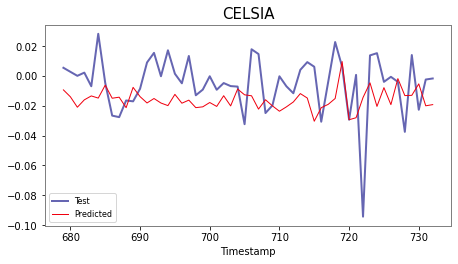

10CEMARGOS
[[0.26650913 0.27864247 0.24157751 0.07792632 0.         0.71775561
  0.29875001 0.47164058 0.59417081]]
[[0.27864247 0.24157751 0.07792632 0.         0.71775561 0.29875001
  0.47164058 0.59417081 0.56434959]]
[[0.24157751 0.07792632 0.         0.71775561 0.29875001 0.47164058
  0.59417081 0.56434959 0.53074306]]
[[0.07792632 0.         0.71775561 0.29875001 0.47164058 0.59417081
  0.56434959 0.53074306 0.56849593]]
[[0.         0.71775561 0.29875001 0.47164058 0.59417081 0.56434959
  0.53074306 0.56849593 0.57197392]]
[[0.71775561 0.29875001 0.47164058 0.59417081 0.56434959 0.53074306
  0.56849593 0.57197392 0.51639754]]
[[0.29875001 0.47164058 0.59417081 0.56434959 0.53074306 0.56849593
  0.57197392 0.51639754 0.52380055]]
[[0.47164058 0.59417081 0.56434959 0.53074306 0.56849593 0.57197392
  0.51639754 0.52380055 0.60137117]]
[[0.59417081 0.56434959 0.53074306 0.56849593 0.57197392 0.51639754
  0.52380055 0.60137117 0.59491497]]
[[0.56434959 0.53074306 0.56849593 0.5719739

54
54


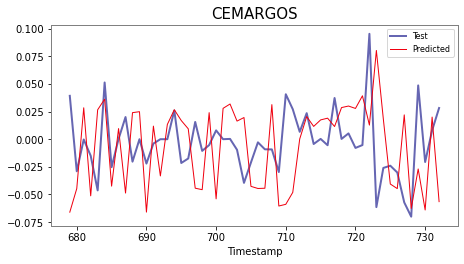

10CLH
[[0.39991831 0.39991831 0.39991831 0.39991831 0.0198336  0.39991831
  0.39991831 0.39991831 0.39991831]]
[[0.39991831 0.39991831 0.39991831 0.0198336  0.39991831 0.39991831
  0.39991831 0.39991831 0.58023047]]
[[0.39991831 0.39991831 0.0198336  0.39991831 0.39991831 0.39991831
  0.39991831 0.58023047 0.56808472]]
[[0.39991831 0.0198336  0.39991831 0.39991831 0.39991831 0.39991831
  0.58023047 0.56808472 0.51195198]]
[[0.0198336  0.39991831 0.39991831 0.39991831 0.39991831 0.58023047
  0.56808472 0.51195198 0.46938843]]
[[0.39991831 0.39991831 0.39991831 0.39991831 0.58023047 0.56808472
  0.51195198 0.46938843 0.55817807]]
[[0.39991831 0.39991831 0.39991831 0.58023047 0.56808472 0.51195198
  0.46938843 0.55817807 0.51546568]]
[[0.39991831 0.39991831 0.58023047 0.56808472 0.51195198 0.46938843
  0.55817807 0.51546568 0.50033349]]
[[0.39991831 0.58023047 0.56808472 0.51195198 0.46938843 0.55817807
  0.51546568 0.50033349 0.50037712]]
[[0.58023047 0.56808472 0.51195198 0.46938843 0.5

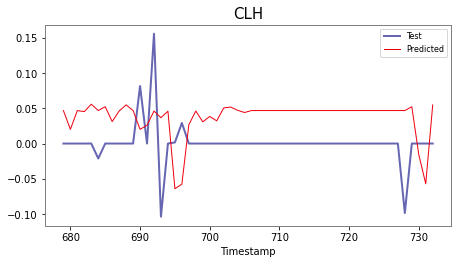

10CNEC
[[0.61354342 0.50403796 0.13463774 0.15649736 0.19030933 0.58994767
  0.62927996 0.54253801 0.3651351 ]]
[[0.50403796 0.13463774 0.15649736 0.19030933 0.58994767 0.62927996
  0.54253801 0.3651351  0.78744304]]
[[0.13463774 0.15649736 0.19030933 0.58994767 0.62927996 0.54253801
  0.3651351  0.78744304 0.42089173]]
[[0.15649736 0.19030933 0.58994767 0.62927996 0.54253801 0.3651351
  0.78744304 0.42089173 0.40744838]]
[[0.19030933 0.58994767 0.62927996 0.54253801 0.3651351  0.78744304
  0.42089173 0.40744838 0.57323587]]
[[0.58994767 0.62927996 0.54253801 0.3651351  0.78744304 0.42089173
  0.40744838 0.57323587 0.48560479]]
[[0.62927996 0.54253801 0.3651351  0.78744304 0.42089173 0.40744838
  0.57323587 0.48560479 0.46917161]]
[[0.54253801 0.3651351  0.78744304 0.42089173 0.40744838 0.57323587
  0.48560479 0.46917161 0.5007875 ]]
[[0.3651351  0.78744304 0.42089173 0.40744838 0.57323587 0.48560479
  0.46917161 0.5007875  0.44182876]]
[[0.78744304 0.42089173 0.40744838 0.57323587 0.4

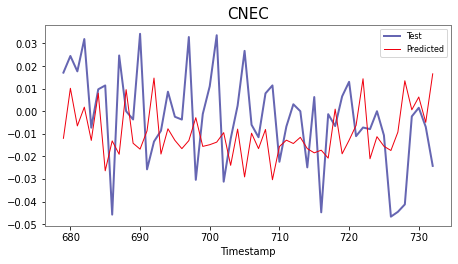

10CORFICOLCF
[[0.76328359 0.86168869 0.8395036  0.10680607 0.33240268 0.91602253
  0.44480084 0.91049357 0.23871471]]
[[0.86168869 0.8395036  0.10680607 0.33240268 0.91602253 0.44480084
  0.91049357 0.23871471 0.58557189]]
[[0.8395036  0.10680607 0.33240268 0.91602253 0.44480084 0.91049357
  0.23871471 0.58557189 0.78761458]]
[[0.10680607 0.33240268 0.91602253 0.44480084 0.91049357 0.23871471
  0.58557189 0.78761458 0.66044766]]
[[0.33240268 0.91602253 0.44480084 0.91049357 0.23871471 0.58557189
  0.78761458 0.66044766 0.78401303]]
[[0.91602253 0.44480084 0.91049357 0.23871471 0.58557189 0.78761458
  0.66044766 0.78401303 0.74514484]]
[[0.44480084 0.91049357 0.23871471 0.58557189 0.78761458 0.66044766
  0.78401303 0.74514484 0.65282285]]
[[0.91049357 0.23871471 0.58557189 0.78761458 0.66044766 0.78401303
  0.74514484 0.65282285 0.70048028]]
[[0.23871471 0.58557189 0.78761458 0.66044766 0.78401303 0.74514484
  0.65282285 0.70048028 0.62478954]]
[[0.58557189 0.78761458 0.66044766 0.78401

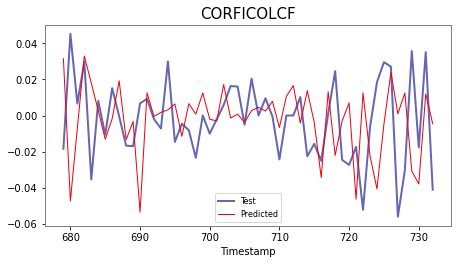

10ECOPETROL
[[0.40137091 0.4554301  0.68240564 0.         0.36037087 0.76332269
  0.73495881 0.65362396 0.56763522]]
[[0.4554301  0.68240564 0.         0.36037087 0.76332269 0.73495881
  0.65362396 0.56763522 0.6105451 ]]
[[0.68240564 0.         0.36037087 0.76332269 0.73495881 0.65362396
  0.56763522 0.6105451  0.54140979]]
[[0.         0.36037087 0.76332269 0.73495881 0.65362396 0.56763522
  0.6105451  0.54140979 0.64864635]]
[[0.36037087 0.76332269 0.73495881 0.65362396 0.56763522 0.6105451
  0.54140979 0.64864635 0.64910924]]
[[0.76332269 0.73495881 0.65362396 0.56763522 0.6105451  0.54140979
  0.64864635 0.64910924 0.54302692]]
[[0.73495881 0.65362396 0.56763522 0.6105451  0.54140979 0.64864635
  0.64910924 0.54302692 0.6696927 ]]
[[0.65362396 0.56763522 0.6105451  0.54140979 0.64864635 0.64910924
  0.54302692 0.6696927  0.66914684]]
[[0.56763522 0.6105451  0.54140979 0.64864635 0.64910924 0.54302692
  0.6696927  0.66914684 0.56424654]]
[[0.6105451  0.54140979 0.64864635 0.6491092

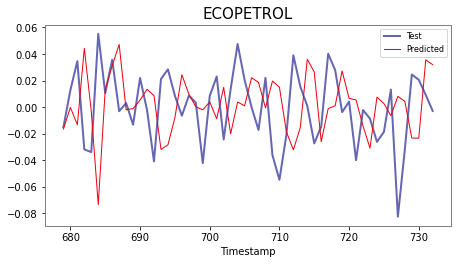

10EXITO
[[0.06804525 0.59298722 0.36559626 0.25291122 0.36559626 0.36559626
  0.3715768  0.36559626 0.0594999 ]]
[[0.59298722 0.36559626 0.25291122 0.36559626 0.36559626 0.3715768
  0.36559626 0.0594999  0.82292426]]
[[0.36559626 0.25291122 0.36559626 0.36559626 0.3715768  0.36559626
  0.0594999  0.82292426 0.2421777 ]]
[[0.25291122 0.36559626 0.36559626 0.3715768  0.36559626 0.0594999
  0.82292426 0.2421777  0.50536811]]
[[0.36559626 0.36559626 0.3715768  0.36559626 0.0594999  0.82292426
  0.2421777  0.50536811 0.41514322]]
[[0.36559626 0.3715768  0.36559626 0.0594999  0.82292426 0.2421777
  0.50536811 0.41514322 0.53701615]]
[[0.3715768  0.36559626 0.0594999  0.82292426 0.2421777  0.50536811
  0.41514322 0.53701615 0.41765231]]
[[0.36559626 0.0594999  0.82292426 0.2421777  0.50536811 0.41514322
  0.53701615 0.41765231 0.52177948]]
[[0.0594999  0.82292426 0.2421777  0.50536811 0.41514322 0.53701615
  0.41765231 0.52177948 0.5372473 ]]
[[0.82292426 0.2421777  0.50536811 0.41514322 0.53

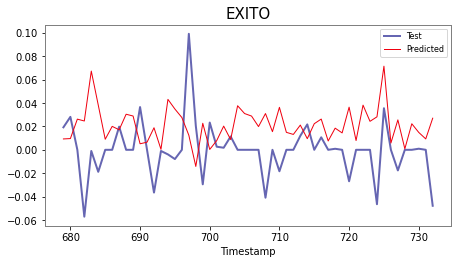

10GRUPOARGOS
[[0.19818341 0.69746007 0.37680216 0.20077519 0.16573016 0.4958012
  0.5308414  0.33486152 0.54309191]]
[[0.69746007 0.37680216 0.20077519 0.16573016 0.4958012  0.5308414
  0.33486152 0.54309191 0.43173721]]
[[0.37680216 0.20077519 0.16573016 0.4958012  0.5308414  0.33486152
  0.54309191 0.43173721 0.40412632]]
[[0.20077519 0.16573016 0.4958012  0.5308414  0.33486152 0.54309191
  0.43173721 0.40412632 0.47496796]]
[[0.16573016 0.4958012  0.5308414  0.33486152 0.54309191 0.43173721
  0.40412632 0.47496796 0.44827729]]
[[0.4958012  0.5308414  0.33486152 0.54309191 0.43173721 0.40412632
  0.47496796 0.44827729 0.44296306]]
[[0.5308414  0.33486152 0.54309191 0.43173721 0.40412632 0.47496796
  0.44827729 0.44296306 0.44243568]]
[[0.33486152 0.54309191 0.43173721 0.40412632 0.47496796 0.44827729
  0.44296306 0.44243568 0.37530762]]
[[0.54309191 0.43173721 0.40412632 0.47496796 0.44827729 0.44296306
  0.44243568 0.37530762 0.44470078]]
[[0.43173721 0.40412632 0.47496796 0.4482772

54
54


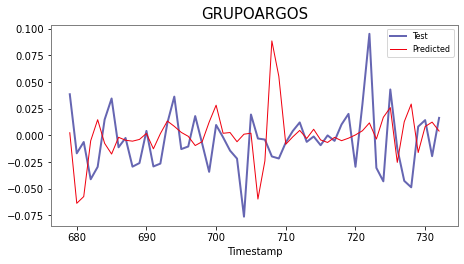

10GRUPOAVAL
[[0.         0.98238687 0.70995035 0.70995035 0.70995035 0.70995035
  0.70995035 0.70995035 0.70995035]]
[[0.98238687 0.70995035 0.70995035 0.70995035 0.70995035 0.70995035
  0.70995035 0.70995035 0.67006689]]
[[0.70995035 0.70995035 0.70995035 0.70995035 0.70995035 0.70995035
  0.70995035 0.67006689 0.6673733 ]]
[[0.70995035 0.70995035 0.70995035 0.70995035 0.70995035 0.70995035
  0.67006689 0.6673733  0.64550734]]
[[0.70995035 0.70995035 0.70995035 0.70995035 0.70995035 0.67006689
  0.6673733  0.64550734 0.61369205]]
[[0.70995035 0.70995035 0.70995035 0.70995035 0.67006689 0.6673733
  0.64550734 0.61369205 0.66899824]]
[[0.70995035 0.70995035 0.70995035 0.67006689 0.6673733  0.64550734
  0.61369205 0.66899824 0.67918181]]
[[0.70995035 0.70995035 0.67006689 0.6673733  0.64550734 0.61369205
  0.66899824 0.67918181 0.6970005 ]]
[[0.70995035 0.67006689 0.6673733  0.64550734 0.61369205 0.66899824
  0.67918181 0.6970005  0.68531787]]
[[0.67006689 0.6673733  0.64550734 0.6136920

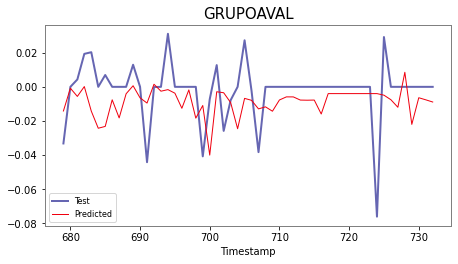

10GRUPOSURA
[[0.66752873 1.         0.50409435 0.50405425 0.56898557 0.25077106
  0.6219578  0.26064962 0.13741695]]
[[1.         0.50409435 0.50405425 0.56898557 0.25077106 0.6219578
  0.26064962 0.13741695 0.56655359]]
[[0.50409435 0.50405425 0.56898557 0.25077106 0.6219578  0.26064962
  0.13741695 0.56655359 0.1966543 ]]
[[0.50405425 0.56898557 0.25077106 0.6219578  0.26064962 0.13741695
  0.56655359 0.1966543  0.56459051]]
[[0.56898557 0.25077106 0.6219578  0.26064962 0.13741695 0.56655359
  0.1966543  0.56459051 0.20222627]]
[[0.25077106 0.6219578  0.26064962 0.13741695 0.56655359 0.1966543
  0.56459051 0.20222627 0.44334438]]
[[0.6219578  0.26064962 0.13741695 0.56655359 0.1966543  0.56459051
  0.20222627 0.44334438 0.82845801]]
[[0.26064962 0.13741695 0.56655359 0.1966543  0.56459051 0.20222627
  0.44334438 0.82845801 0.58231235]]
[[0.13741695 0.56655359 0.1966543  0.56459051 0.20222627 0.44334438
  0.82845801 0.58231235 0.38921082]]
[[0.56655359 0.1966543  0.56459051 0.20222627

[[0.4339076  0.42869624 0.4356612  0.46136537 0.44901606 0.44959921
  0.44392434 0.46102452 0.46846354]]
[[0.42869624 0.4356612  0.46136537 0.44901606 0.44959921 0.44392434
  0.46102452 0.46846354 0.4376983 ]]
[[0.4356612  0.46136537 0.44901606 0.44959921 0.44392434 0.46102452
  0.46846354 0.4376983  0.45604348]]
[[0.46136537 0.44901606 0.44959921 0.44392434 0.46102452 0.46846354
  0.4376983  0.45604348 0.40314963]]
54
54


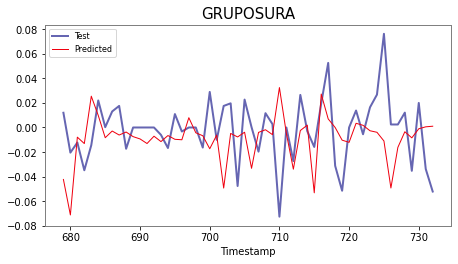

10ISA
[[0.18947568 0.29444452 0.48265772 0.11959105 0.15083434 0.99133771
  0.75139323 0.92165168 0.63223509]]
[[0.29444452 0.48265772 0.11959105 0.15083434 0.99133771 0.75139323
  0.92165168 0.63223509 0.76692224]]
[[0.48265772 0.11959105 0.15083434 0.99133771 0.75139323 0.92165168
  0.63223509 0.76692224 0.80057168]]
[[0.11959105 0.15083434 0.99133771 0.75139323 0.92165168 0.63223509
  0.76692224 0.80057168 0.71532488]]
[[0.15083434 0.99133771 0.75139323 0.92165168 0.63223509 0.76692224
  0.80057168 0.71532488 0.68774921]]
[[0.99133771 0.75139323 0.92165168 0.63223509 0.76692224 0.80057168
  0.71532488 0.68774921 0.64199907]]
[[0.75139323 0.92165168 0.63223509 0.76692224 0.80057168 0.71532488
  0.68774921 0.64199907 0.63097465]]
[[0.92165168 0.63223509 0.76692224 0.80057168 0.71532488 0.68774921
  0.64199907 0.63097465 0.6000948 ]]
[[0.63223509 0.76692224 0.80057168 0.71532488 0.68774921 0.64199907
  0.63097465 0.6000948  0.64382273]]
[[0.76692224 0.80057168 0.71532488 0.68774921 0.6

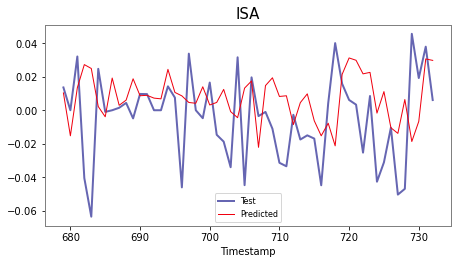

5NUTRESA
[[0.60235749 0.60235749 0.60235749 0.60235749]]
[[0.60235749 0.60235749 0.60235749 0.35434416]]
[[0.60235749 0.60235749 0.35434416 0.35154083]]
[[0.60235749 0.35434416 0.35154083 0.35109356]]
[[0.35434416 0.35154083 0.35109356 0.35581571]]
[[0.35154083 0.35109356 0.35581571 0.36509222]]
[[0.35109356 0.35581571 0.36509222 0.36509222]]
[[0.35581571 0.36509222 0.36509222 0.36509222]]
[[0.36509222 0.36509222 0.36509222 0.35768914]]
[[0.36509222 0.36509222 0.35768914 0.35768914]]
[[0.36509222 0.35768914 0.35768914 0.35768914]]
[[0.35768914 0.35768914 0.35768914 0.36509222]]
[[0.35768914 0.35768914 0.36509222 0.36509222]]
[[0.35768914 0.36509222 0.36509222 0.36509222]]
[[0.36509222 0.36509222 0.36509222 0.35768914]]
[[0.36509222 0.36509222 0.35768914 0.35768914]]
[[0.36509222 0.35768914 0.35768914 0.35768914]]
[[0.35768914 0.35768914 0.35768914 0.36509222]]
[[0.35768914 0.35768914 0.36509222 0.36509222]]
[[0.35768914 0.36509222 0.36509222 0.36509222]]
[[0.36509222 0.36509222 0.36509

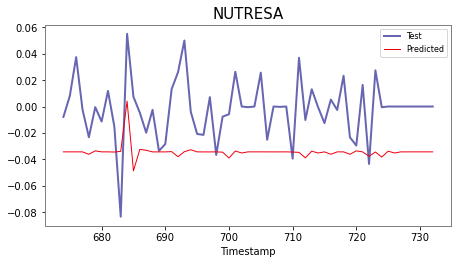

10PFAVAL
[[0.56533406 0.24068084 0.48872773 0.12040859 0.09771702 0.53585272
  0.45344945 0.03812482 0.36910909]]
[[0.24068084 0.48872773 0.12040859 0.09771702 0.53585272 0.45344945
  0.03812482 0.36910909 0.26701483]]
[[0.48872773 0.12040859 0.09771702 0.53585272 0.45344945 0.03812482
  0.36910909 0.26701483 0.41556197]]
[[0.12040859 0.09771702 0.53585272 0.45344945 0.03812482 0.36910909
  0.26701483 0.41556197 0.5495218 ]]
[[0.09771702 0.53585272 0.45344945 0.03812482 0.36910909 0.26701483
  0.41556197 0.5495218  0.25526553]]
[[0.53585272 0.45344945 0.03812482 0.36910909 0.26701483 0.41556197
  0.5495218  0.25526553 0.5565694 ]]
[[0.45344945 0.03812482 0.36910909 0.26701483 0.41556197 0.5495218
  0.25526553 0.5565694  0.17677246]]
[[0.03812482 0.36910909 0.26701483 0.41556197 0.5495218  0.25526553
  0.5565694  0.17677246 0.48711607]]
[[0.36910909 0.26701483 0.41556197 0.5495218  0.25526553 0.5565694
  0.17677246 0.48711607 0.31715319]]
[[0.26701483 0.41556197 0.5495218  0.25526553 0.

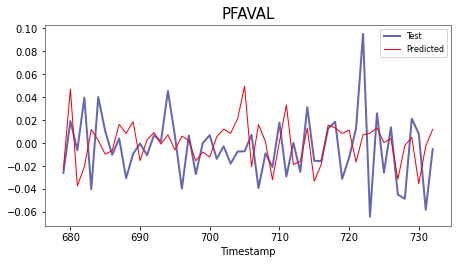

10PFCEMARGOS
[[0.         0.6496033  0.138253   0.34204775 0.34159876 0.39525244
  0.39525244 0.17599197 0.39525244]]
[[0.6496033  0.138253   0.34204775 0.34159876 0.39525244 0.39525244
  0.17599197 0.39525244 0.5607326 ]]
[[0.138253   0.34204775 0.34159876 0.39525244 0.39525244 0.17599197
  0.39525244 0.5607326  0.17105114]]
[[0.34204775 0.34159876 0.39525244 0.39525244 0.17599197 0.39525244
  0.5607326  0.17105114 0.51263714]]
[[0.34159876 0.39525244 0.39525244 0.17599197 0.39525244 0.5607326
  0.17105114 0.51263714 0.44307563]]
[[0.39525244 0.39525244 0.17599197 0.39525244 0.5607326  0.17105114
  0.51263714 0.44307563 0.4549512 ]]
[[0.39525244 0.17599197 0.39525244 0.5607326  0.17105114 0.51263714
  0.44307563 0.4549512  0.54124016]]
[[0.17599197 0.39525244 0.5607326  0.17105114 0.51263714 0.44307563
  0.4549512  0.54124016 0.37088341]]
[[0.39525244 0.5607326  0.17105114 0.51263714 0.44307563 0.4549512
  0.54124016 0.37088341 0.54455465]]
[[0.5607326  0.17105114 0.51263714 0.4430756

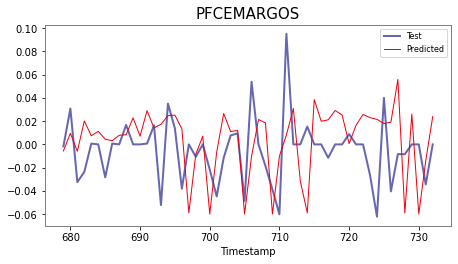

10PFCORFICOL
[[0.18500938 0.81906104 0.74788192 0.44119788 0.         0.50203521
  0.50203521 0.50203521 0.17347867]]
[[0.81906104 0.74788192 0.44119788 0.         0.50203521 0.50203521
  0.50203521 0.17347867 0.53141451]]
[[0.74788192 0.44119788 0.         0.50203521 0.50203521 0.50203521
  0.17347867 0.53141451 0.61387795]]
[[0.44119788 0.         0.50203521 0.50203521 0.50203521 0.17347867
  0.53141451 0.61387795 0.45990819]]
[[0.         0.50203521 0.50203521 0.50203521 0.17347867 0.53141451
  0.61387795 0.45990819 0.43059203]]
[[0.50203521 0.50203521 0.50203521 0.17347867 0.53141451 0.61387795
  0.45990819 0.43059203 0.45881346]]
[[0.50203521 0.50203521 0.17347867 0.53141451 0.61387795 0.45990819
  0.43059203 0.45881346 0.61395144]]
[[0.50203521 0.17347867 0.53141451 0.61387795 0.45990819 0.43059203
  0.45881346 0.61395144 0.58407497]]
[[0.17347867 0.53141451 0.61387795 0.45990819 0.43059203 0.45881346
  0.61395144 0.58407497 0.58983958]]
[[0.53141451 0.61387795 0.45990819 0.43059

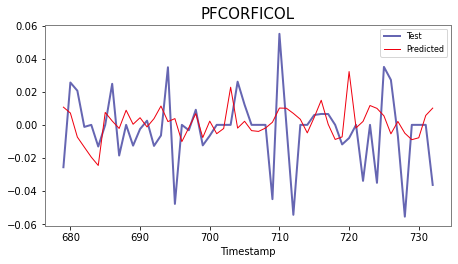

10PFDAVVNDA
[[0.4498636  0.39019318 0.50341558 0.4496884  0.42600508 0.12531863
  0.37078206 0.74042712 0.46453553]]
[[0.39019318 0.50341558 0.4496884  0.42600508 0.12531863 0.37078206
  0.74042712 0.46453553 0.54945928]]
[[0.50341558 0.4496884  0.42600508 0.12531863 0.37078206 0.74042712
  0.46453553 0.54945928 0.4350729 ]]
[[0.4496884  0.42600508 0.12531863 0.37078206 0.74042712 0.46453553
  0.54945928 0.4350729  0.62726521]]
[[0.42600508 0.12531863 0.37078206 0.74042712 0.46453553 0.54945928
  0.4350729  0.62726521 0.54681969]]
[[0.12531863 0.37078206 0.74042712 0.46453553 0.54945928 0.4350729
  0.62726521 0.54681969 0.51977473]]
[[0.37078206 0.74042712 0.46453553 0.54945928 0.4350729  0.62726521
  0.54681969 0.51977473 0.42358434]]
[[0.74042712 0.46453553 0.54945928 0.4350729  0.62726521 0.54681969
  0.51977473 0.42358434 0.46074995]]
[[0.46453553 0.54945928 0.4350729  0.62726521 0.54681969 0.51977473
  0.42358434 0.46074995 0.55981195]]
[[0.54945928 0.4350729  0.62726521 0.5468196

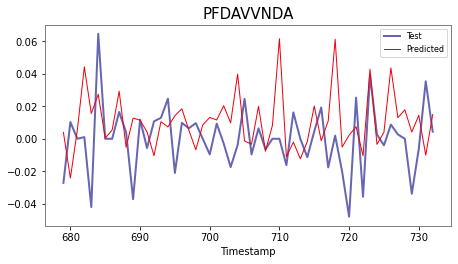

10PFGRUPOARG
[[0.44299335 1.         0.47331901 0.27110858 0.47865728 0.1276384
  0.9267438  0.56098923 0.55577122]]
[[1.         0.47331901 0.27110858 0.47865728 0.1276384  0.9267438
  0.56098923 0.55577122 0.77016872]]
[[0.47331901 0.27110858 0.47865728 0.1276384  0.9267438  0.56098923
  0.55577122 0.77016872 0.54347652]]
[[0.27110858 0.47865728 0.1276384  0.9267438  0.56098923 0.55577122
  0.77016872 0.54347652 0.55242854]]
[[0.47865728 0.1276384  0.9267438  0.56098923 0.55577122 0.77016872
  0.54347652 0.55242854 0.5354656 ]]
[[0.1276384  0.9267438  0.56098923 0.55577122 0.77016872 0.54347652
  0.55242854 0.5354656  0.55214643]]
[[0.9267438  0.56098923 0.55577122 0.77016872 0.54347652 0.55242854
  0.5354656  0.55214643 0.69179106]]
[[0.56098923 0.55577122 0.77016872 0.54347652 0.55242854 0.5354656
  0.55214643 0.69179106 0.63940239]]
[[0.55577122 0.77016872 0.54347652 0.55242854 0.5354656  0.55214643
  0.69179106 0.63940239 0.55968857]]
[[0.77016872 0.54347652 0.55242854 0.5354656 

54
54


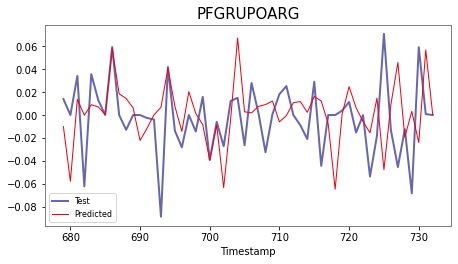

10PFGRUPSURA
[[0.55607439 0.70683272 0.7324098  0.36359863 0.27503756 0.65407217
  0.44193625 0.55624052 0.61342934]]
[[0.70683272 0.7324098  0.36359863 0.27503756 0.65407217 0.44193625
  0.55624052 0.61342934 0.63573003]]
[[0.7324098  0.36359863 0.27503756 0.65407217 0.44193625 0.55624052
  0.61342934 0.63573003 0.5419063 ]]
[[0.36359863 0.27503756 0.65407217 0.44193625 0.55624052 0.61342934
  0.63573003 0.5419063  0.49887994]]
[[0.27503756 0.65407217 0.44193625 0.55624052 0.61342934 0.63573003
  0.5419063  0.49887994 0.57030272]]
[[0.65407217 0.44193625 0.55624052 0.61342934 0.63573003 0.5419063
  0.49887994 0.57030272 0.54825658]]
[[0.44193625 0.55624052 0.61342934 0.63573003 0.5419063  0.49887994
  0.57030272 0.54825658 0.57812095]]
[[0.55624052 0.61342934 0.63573003 0.5419063  0.49887994 0.57030272
  0.54825658 0.57812095 0.56005806]]
[[0.61342934 0.63573003 0.5419063  0.49887994 0.57030272 0.54825658
  0.57812095 0.56005806 0.56334496]]
[[0.63573003 0.5419063  0.49887994 0.570302

[[0.57146788 0.56755543 0.58539116 0.56803745 0.56289792 0.55371219
  0.56932491 0.54195267 0.56096458]]
[[0.56755543 0.58539116 0.56803745 0.56289792 0.55371219 0.56932491
  0.54195267 0.56096458 0.56841296]]
[[0.58539116 0.56803745 0.56289792 0.55371219 0.56932491 0.54195267
  0.56096458 0.56841296 0.54826742]]
[[0.56803745 0.56289792 0.55371219 0.56932491 0.54195267 0.56096458
  0.56841296 0.54826742 0.58915263]]
[[0.56289792 0.55371219 0.56932491 0.54195267 0.56096458 0.56841296
  0.54826742 0.58915263 0.57248938]]
[[0.55371219 0.56932491 0.54195267 0.56096458 0.56841296 0.54826742
  0.58915263 0.57248938 0.56213999]]
[[0.56932491 0.54195267 0.56096458 0.56841296 0.54826742 0.58915263
  0.57248938 0.56213999 0.58437431]]
[[0.54195267 0.56096458 0.56841296 0.54826742 0.58915263 0.57248938
  0.56213999 0.58437431 0.56348395]]
[[0.56096458 0.56841296 0.54826742 0.58915263 0.57248938 0.56213999
  0.58437431 0.56348395 0.5619964 ]]
[[0.56841296 0.54826742 0.58915263 0.57248938 0.5621399

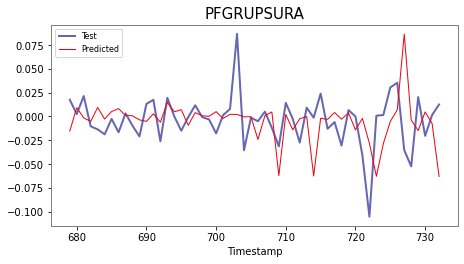

In [46]:
j=0
metricas_base_df = pd.DataFrame(columns=['Acción', 'RMSE','MAE','MAPE'],
                                index=range(len(acciones)))

for i in acciones:
    
#     serie.set_index('fecha',inplace=True)
#     idx = pd.date_range(serie.index.min(), serie.index.max())
#     idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(dias_predecir,'D'))
    
    scaler = MinMaxScaler()    
    df_interes = df_final[df_final['nemotecnico']==i].reset_index()     
    parmetros_optimos = result_df_xgboost[result_df_xgboost['Acción']==i].reset_index(drop=True)
    timesteps = parmetros_optimos.iloc[0,1] 
    
    #### Train ###########
    train = df_interes.copy()[(df_interes['fecha'] < fecha_inicio_test)]    
    train = train[[variable_inte]]
    train[variable_inte] = scaler.fit_transform(pd.DataFrame(train[variable_inte].tolist()))
    train_data = train.values
    #timesteps= parameters_list[j][0]
    train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
    x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
            
    #### test ###########
    test = df_interes.copy()[(df_interes['fecha'] >= fecha_inicio_test)] 
    test = test[[variable_inte]] 
    test[variable_inte] = scaler.fit_transform(pd.DataFrame(test[variable_inte].tolist()))
    test_data = test.values
    test_data_timesteps = np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
    print(str(timesteps)+ str(i))
    x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

    
    model =  xg.XGBRegressor(objective='reg:squarederror',n_estimators = parmetros_optimos.iloc[0,2] ,
                max_depth = parmetros_optimos.iloc[0,3], 
                min_child_weight = parmetros_optimos.iloc[0,5],
                learning_rate = parmetros_optimos.iloc[0,4],seed=1234)
    
    model.fit(x_train, y_train[:,0])
    
    
    
    ### Guardando los modelos
    
    import pickle
    
    path_model='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/modelos/'

    file_name = path_model+ str(i)+'_model_xgb_2.pkl'
    pickle.dump(model, open(file_name, "wb"))
    
    ### Continuando con la prediccion
    
    y_test_pred = model.predict(x_test).reshape(-1,1)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_test = scaler.inverse_transform(y_test)
    
    test_timestamps = df_interes[(df_interes['fecha'] >= fecha_inicio_test)].index[timesteps-1:]
    
#     test = df_interes.copy()[(df_interes['fecha'] > fecha_inicio_test)] 
#     test = test[[variable_inte]][4:]
    

    mape = round(mean_absolute_percentage_error(y_test, y_test_pred)*100,4)
    MAE = round(mean_absolute_error(y_test,y_test_pred),5)
    MSE = mean_squared_error(y_test, y_test_pred) 
    RMSE = round(math.sqrt(MSE),5)

    metricas_base_df.iloc[j][0] = i
    metricas_base_df.iloc[j][1] = RMSE
    metricas_base_df.iloc[j][2] = MAE
    metricas_base_df.iloc[j][3] = mape
    j = j +1
    
    ### Haciendo pronostico de proximos 90 dias

    dias_predecir=90
    results=[]
    timesteps=timesteps-1
    x_test = np.array([[j for j in test_data[i+1:i+timesteps+1]] for i in range(0,len(test_data)-timesteps)])[:,:,0]
    
    incio=x_test[-1:].reshape(1, 1, x_test.shape[1])
    for k in range(dias_predecir):
        print(incio[0])
        parcial=model.predict(incio[0])
        parcial_=scaler.inverse_transform(parcial.reshape(-1, 1))
        results.append(parcial_[0][0])
        incio=agregarNuevoValor(incio,parcial.reshape(-1, 1))
    result=pd.DataFrame(results)[0]
    
    predicciones=pd.DataFrame(result)
    predicciones.rename(columns={0:variable_inte},inplace=True)
    
    
#     path_pronosticos='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos/'

#     writer=pd.ExcelWriter(path_pronosticos + 'pronostico_xgb_vf_1_' + str(i)+'.xlsx',engine='openpyxl')
#     predicciones.to_excel(writer, sheet_name=f'{i}',index=False)
#     writer.save()
    
    #graficando test vs estimacion
    
    print(len(test_timestamps))
    print(len(y_test_pred))
       
    plt.figure(figsize=(7.28, 3.7 ))
    test_data= scaler.inverse_transform(test_data)
    num_periodo_proyeccion=90
    datos_grafico = pd.concat([df_interes[[variable_inte]],predicciones],axis = 0).reset_index(drop=True)
    pronostico_timestamps = datos_grafico.index[datos_grafico.shape[0]-(num_periodo_proyeccion+1):datos_grafico.shape[0]]
    
#     plt.plot(test.index, test_data, color = '#000080', linewidth=2, alpha = 0.6)
#     plt.plot(test_timestamps, y_test_pred, color = '#F0000F', linewidth=1)
#     plt.plot(pronostico_timestamps, datos_grafico[datos_grafico.shape[0]-(num_periodo_proyeccion+1):datos_grafico.shape[0]].values, c='m', linewidth=1)
#     plt.legend(['Test','Predicted','Predicción 90 Dias'],loc=0, fontsize = 8)
#     plt.xlabel('Timestamp')
#     plt.title(i, fontsize = 15)
    #plt.savefig(path_grafico + 'grafico_comparacion_prediccion_1_'+str(i)+'.jpg',facecolor='white')
    
    
    plt.plot(test_timestamps, test_data[-len(y_test_pred):], color = '#000080', linewidth=2, alpha = 0.6)
    plt.plot(test_timestamps, y_test_pred, color = '#F0000F', linewidth=1)
    #plt.plot(range(test.data[-1],731 + 90),result,c='m')
    plt.legend(['Test','Predicted'],loc=0, fontsize = 8)
    plt.xlabel('Timestamp')
    plt.title(i, fontsize = 15)
    plt.savefig(path_grafico + 'grafico_comparacion_prediccion_1_train_test_'+str(i)+'.jpg',facecolor='white')

    
    plt.show()
    
    

In [81]:
import pickle

In [83]:
x_test

array([[0.70011003, 0.77027647, 0.57770652, 0.63660826, 0.62157685,
        0.47282213, 0.64290996, 0.21945118, 0.43791425],
       [0.77027647, 0.57770652, 0.63660826, 0.62157685, 0.47282213,
        0.64290996, 0.21945118, 0.43791425, 0.66234164],
       [0.57770652, 0.63660826, 0.62157685, 0.47282213, 0.64290996,
        0.21945118, 0.43791425, 0.66234164, 0.82166454],
       [0.63660826, 0.62157685, 0.47282213, 0.64290996, 0.21945118,
        0.43791425, 0.66234164, 0.82166454, 0.68406992],
       [0.62157685, 0.47282213, 0.64290996, 0.21945118, 0.43791425,
        0.66234164, 0.82166454, 0.68406992, 0.57770652],
       [0.47282213, 0.64290996, 0.21945118, 0.43791425, 0.66234164,
        0.82166454, 0.68406992, 0.57770652, 0.64707721],
       [0.64290996, 0.21945118, 0.43791425, 0.66234164, 0.82166454,
        0.68406992, 0.57770652, 0.64707721, 0.40625649],
       [0.21945118, 0.43791425, 0.66234164, 0.82166454, 0.68406992,
        0.57770652, 0.64707721, 0.40625649, 0.82202702],


In [25]:
metricas_base_df.head()

,Acción,RMSE,MAE,MAPE
0,BCOLOMBIA,0.03295,0.0261,494062804567455.75
1,BOGOTA,0.03318,0.02577,1181311278436773.75
2,BVC,0.02695,0.02063,1952923335490606.75
3,CELSIA,0.02279,0.01817,175442143915372.5
4,CEMARGOS,0.04839,0.03914,828437115700244.0


In [26]:
path_model='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/modelos/'

In [27]:
metricas_base_df.to_csv(path_model+'metricas_model_xgboost_1.csv', sep='|')
metricas_base_df

,Acción,RMSE,MAE,MAPE
0,BCOLOMBIA,0.03295,0.0261,494062804567455.75
1,BOGOTA,0.03318,0.02577,1181311278436773.75
2,BVC,0.02695,0.02063,1952923335490606.75
3,CELSIA,0.02279,0.01817,175442143915372.5
4,CEMARGOS,0.04839,0.03914,828437115700244.0
5,CLH,0.05612,0.05135,17474396333306406.0
6,CNEC,0.02536,0.02072,270295909444470.03125
7,CORFICOLCF,0.03049,0.02277,368316242451202.1875
8,ECOPETROL,0.04099,0.0329,184736892458008.59375
9,EXITO,0.03715,0.02943,3859348394257373.5


### Leyendo los pronosticos para concatenarlos

In [50]:
import os
os.getcwd()

'C:\\Users\\USUARIO\\Downloads'

In [51]:
path = "C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos"
dir_list = os.listdir(path)

print("Archivos y Carpetas en'", path, "' :")
print('\n')
print(dir_list)


Archivos y Carpetas en' C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos ' :


['consolidado_pronosticos_xgb.xlsx', 'consolidado_pronosticos_xgb_1.xlsx', 'pronostico_xgb_BCOLOMBIA.xlsx', 'pronostico_xgb_BOGOTA.xlsx', 'pronostico_xgb_BVC.xlsx', 'pronostico_xgb_CELSIA.xlsx', 'pronostico_xgb_CEMARGOS.xlsx', 'pronostico_xgb_vf_1_BCOLOMBIA.xlsx', 'pronostico_xgb_vf_1_BOGOTA.xlsx', 'pronostico_xgb_vf_1_BVC.xlsx', 'pronostico_xgb_vf_1_CELSIA.xlsx', 'pronostico_xgb_vf_1_CEMARGOS.xlsx', 'pronostico_xgb_vf_1_CLH.xlsx', 'pronostico_xgb_vf_1_CNEC.xlsx', 'pronostico_xgb_vf_1_CORFICOLCF.xlsx', 'pronostico_xgb_vf_1_ECOPETROL.xlsx', 'pronostico_xgb_vf_1_EXITO.xlsx', 'pronostico_xgb_vf_1_GRUPOARGOS.xlsx', 'pronostico_xgb_vf_1_GRUPOAVAL.xlsx', 'pronostico_xgb_vf_1_GRUPOSURA.xlsx', 'pronostico_xgb_vf_1_ISA.xlsx', 'pronostico_xgb_vf_1_NUTRESA.xlsx', 'pronostico_xgb_vf_1_PFAVAL.xlsx', 'pronostico_xgb_vf_1_PFCEMARGOS.xlsx', 'pronostico_xgb_vf_1_PFCO

In [52]:
dir_list=[x for x in dir_list if 'pronostico_xgb_vf_1_' in x]
print('catidad de archivos asociados a las acciones fueron cargados:',len(dir_list))
dir_list

catidad de archivos asociados a las acciones fueron cargados: 21


['pronostico_xgb_vf_1_BCOLOMBIA.xlsx',
 'pronostico_xgb_vf_1_BOGOTA.xlsx',
 'pronostico_xgb_vf_1_BVC.xlsx',
 'pronostico_xgb_vf_1_CELSIA.xlsx',
 'pronostico_xgb_vf_1_CEMARGOS.xlsx',
 'pronostico_xgb_vf_1_CLH.xlsx',
 'pronostico_xgb_vf_1_CNEC.xlsx',
 'pronostico_xgb_vf_1_CORFICOLCF.xlsx',
 'pronostico_xgb_vf_1_ECOPETROL.xlsx',
 'pronostico_xgb_vf_1_EXITO.xlsx',
 'pronostico_xgb_vf_1_GRUPOARGOS.xlsx',
 'pronostico_xgb_vf_1_GRUPOAVAL.xlsx',
 'pronostico_xgb_vf_1_GRUPOSURA.xlsx',
 'pronostico_xgb_vf_1_ISA.xlsx',
 'pronostico_xgb_vf_1_NUTRESA.xlsx',
 'pronostico_xgb_vf_1_PFAVAL.xlsx',
 'pronostico_xgb_vf_1_PFCEMARGOS.xlsx',
 'pronostico_xgb_vf_1_PFCORFICOL.xlsx',
 'pronostico_xgb_vf_1_PFDAVVNDA.xlsx',
 'pronostico_xgb_vf_1_PFGRUPOARG.xlsx',
 'pronostico_xgb_vf_1_PFGRUPSURA.xlsx']

In [42]:
str('pronostico_xgb_vf_1_NUTRESA.xlsx')[20:-5]

'NUTRESA'

In [33]:
ejemplo=pd.read_excel('C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos/pronostico_xgb_vf_1_BCOLOMBIA.xlsx')
print(ejemplo.shape)
ejemplo.head()

(90, 1)


,variacion_log
0,-0.031886
1,-0.031453
2,-0.036252
3,-0.011974
4,-0.011589


In [44]:
df_list=[]

for i in dir_list:
    temp_df = pd.read_excel(path + '/' + i)
    print(str(i)[20:-5])
    #temp_df['nemotecnico']=str(i)[18:-5]
    temp_df['nemotecnico']=str(i)[20:-5]
    #temp_df.rename(columns={0:'pronostico'},inplace=True)
    temp_df.rename(columns={'variacion_log':'pronostico'},inplace=True)
    temp_df=temp_df[['nemotecnico','pronostico']]
    print('Tamaño Base:',temp_df.shape)
    print('\n')
    df_list.append(temp_df)
    
df_pronostico = pd.concat(df_list)
print('Tamaño Base unida:', df_pronostico.shape)
df_pronostico.head()

BCOLOMBIA
Tamaño Base: (90, 2)


BOGOTA
Tamaño Base: (90, 2)


BVC
Tamaño Base: (90, 2)


CELSIA
Tamaño Base: (90, 2)


CEMARGOS
Tamaño Base: (90, 2)


CLH
Tamaño Base: (90, 2)


CNEC
Tamaño Base: (90, 2)


CORFICOLCF
Tamaño Base: (90, 2)


ECOPETROL
Tamaño Base: (90, 2)


EXITO
Tamaño Base: (90, 2)


GRUPOARGOS
Tamaño Base: (90, 2)


GRUPOAVAL
Tamaño Base: (90, 2)


GRUPOSURA
Tamaño Base: (90, 2)


ISA
Tamaño Base: (90, 2)


NUTRESA
Tamaño Base: (90, 2)


PFAVAL
Tamaño Base: (90, 2)


PFCEMARGOS
Tamaño Base: (90, 2)


PFCORFICOL
Tamaño Base: (90, 2)


PFDAVVNDA
Tamaño Base: (90, 2)


PFGRUPOARG
Tamaño Base: (90, 2)


PFGRUPSURA
Tamaño Base: (90, 2)


Tamaño Base unida: (1890, 2)


,nemotecnico,pronostico
0,BCOLOMBIA,-0.031886
1,BCOLOMBIA,-0.031453
2,BCOLOMBIA,-0.036252
3,BCOLOMBIA,-0.011974
4,BCOLOMBIA,-0.011589


In [45]:
path_pronosticos

'C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos/'

In [46]:
df_pronostico.columns

Index(['nemotecnico', 'pronostico'], dtype='object')

In [47]:
df_pronostico.to_excel(path_pronosticos + 'consolidado_pronosticos_xgb_1.xlsx',index=False)

In [48]:
df_pronostico.groupby('nemotecnico').describe()['pronostico']

,count,mean,std,min,25%,50%,75%,max
nemotecnico,,,,,,,,
BCOLOMBIA,90.0,-0.014762,0.004573,-0.036252,-0.016227,-0.014357,-0.011970,-0.007065
BOGOTA,90.0,0.026783,0.003456,0.010134,0.026682,0.027659,0.028392,0.033192
BVC,90.0,-0.007521,0.007122,-0.026847,-0.012602,-0.006784,-0.000843,0.008519
CELSIA,90.0,-0.011999,0.002549,-0.019312,-0.013542,-0.012165,-0.010693,-0.003484
CEMARGOS,90.0,0.024405,0.002630,0.015345,0.023133,0.024273,0.025899,0.030191
CLH,90.0,0.033720,0.006519,0.018031,0.030229,0.033880,0.037956,0.047875
CNEC,90.0,-0.012552,0.003855,-0.020102,-0.014205,-0.012902,-0.011672,0.016962
CORFICOLCF,90.0,0.007281,0.002992,-0.001742,0.006031,0.006839,0.007822,0.021162
ECOPETROL,90.0,0.008997,0.003891,-0.006569,0.007468,0.009091,0.010936,0.019846


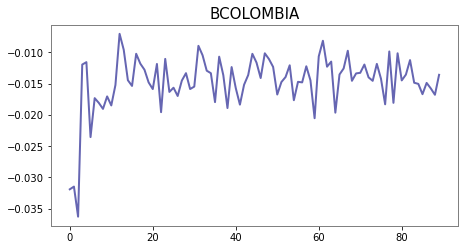

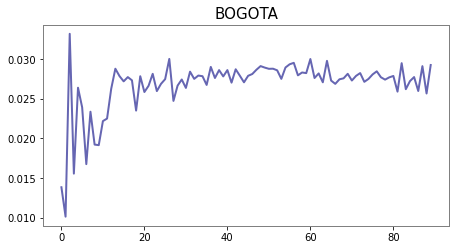

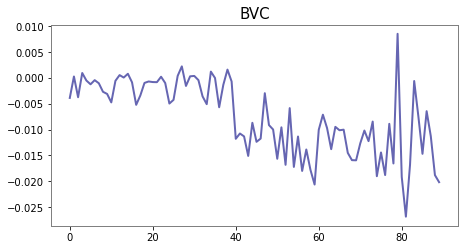

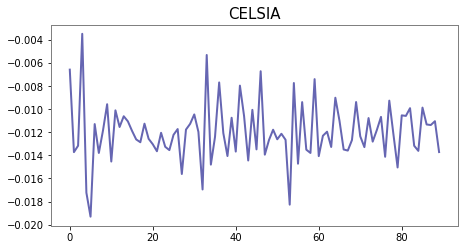

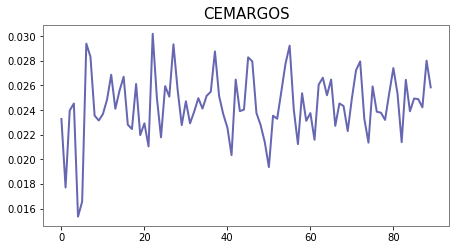

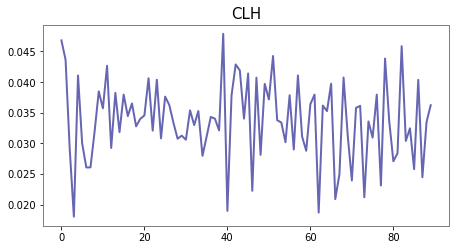

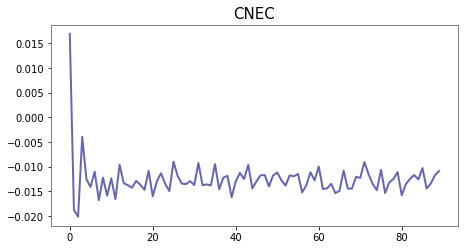

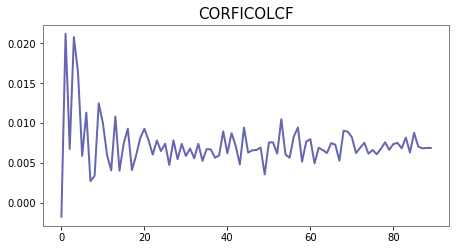

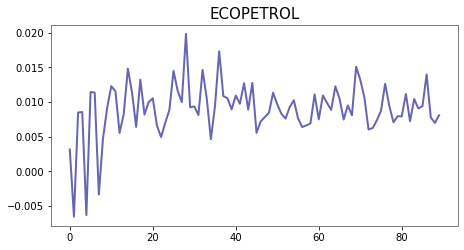

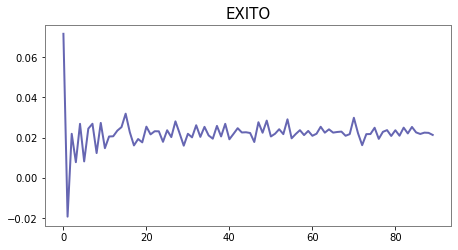

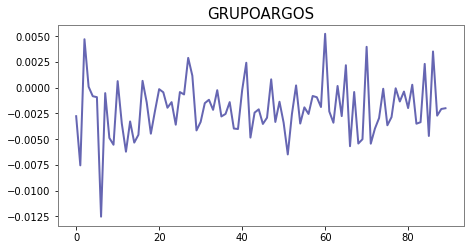

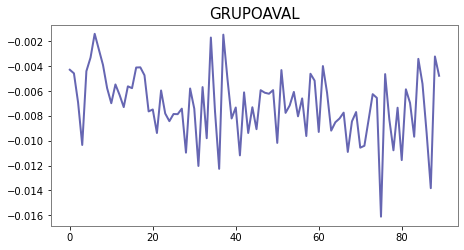

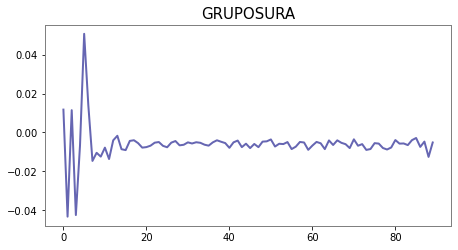

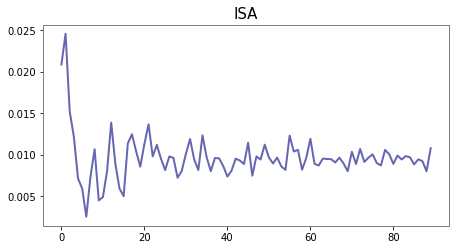

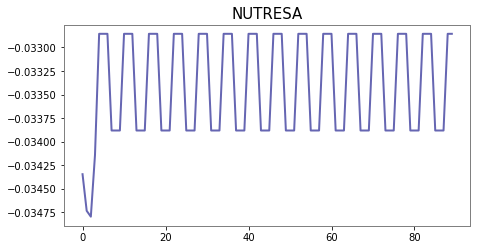

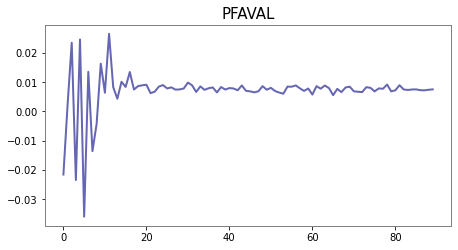

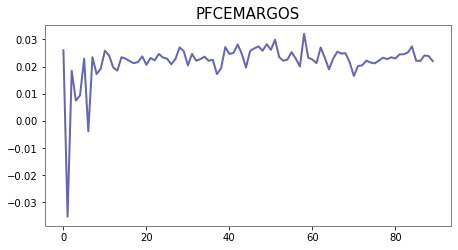

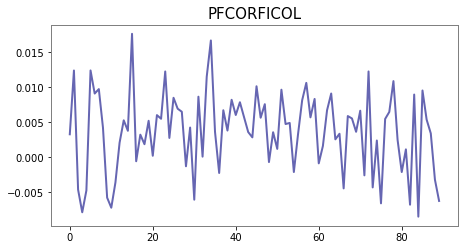

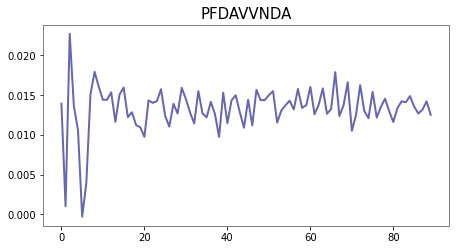

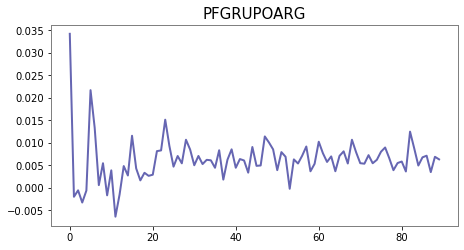

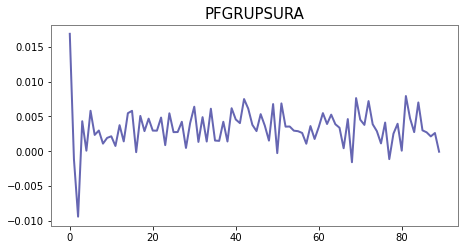

In [49]:
for i in acciones:

    plt.figure(figsize=(7.28, 3.7 ))
    plt.plot(range(0,90), df_pronostico[df_pronostico['nemotecnico']==i]['pronostico'], color = '#000080', linewidth=2, alpha = 0.6)
    plt.title(i, fontsize = 15)
    plt.show()

### pronosticos

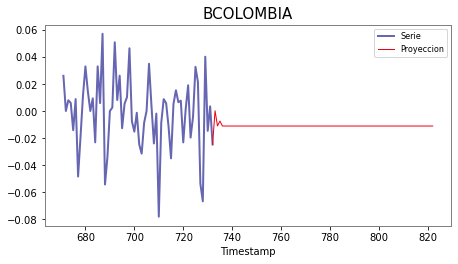

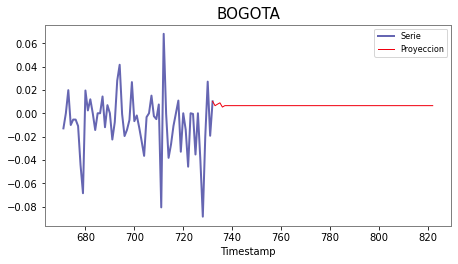

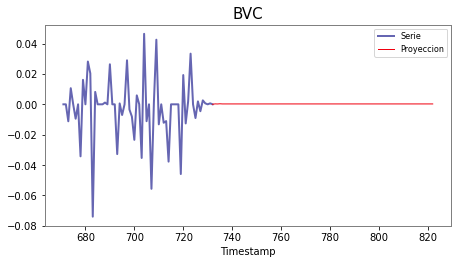

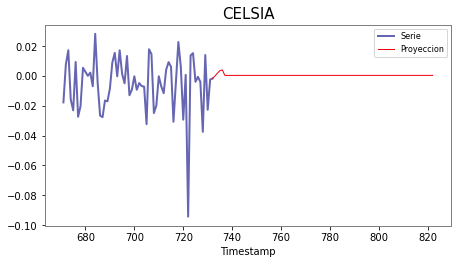

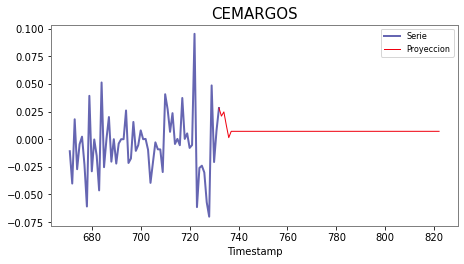

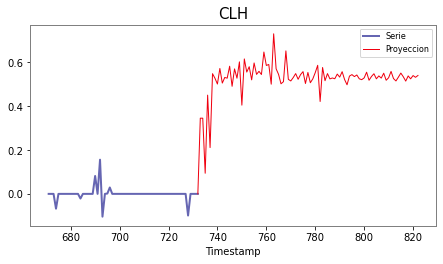

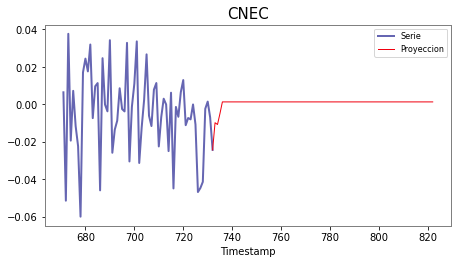

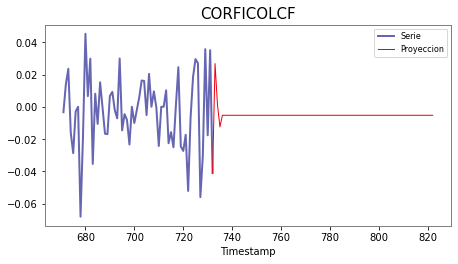

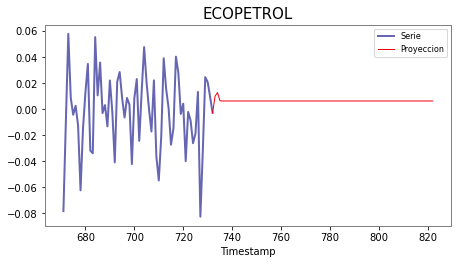

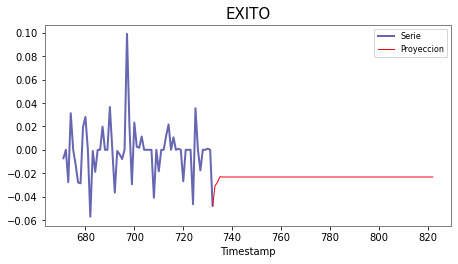

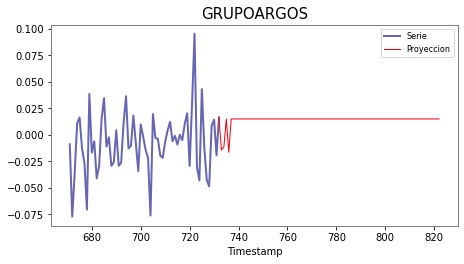

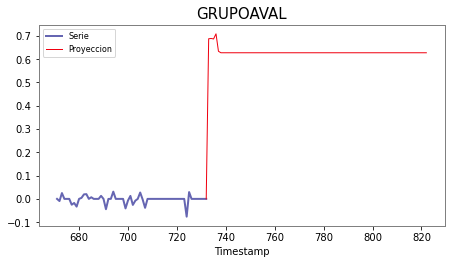

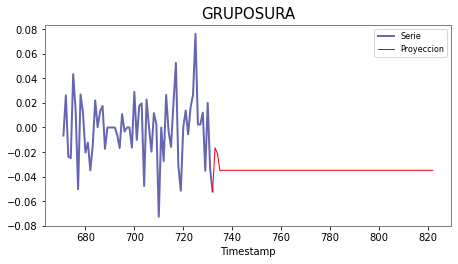

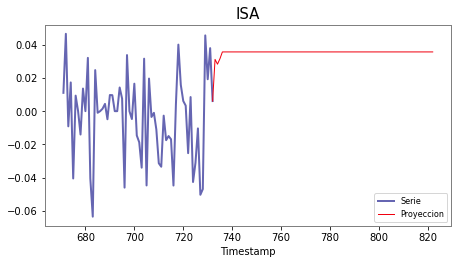

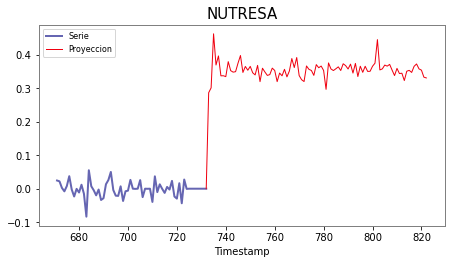

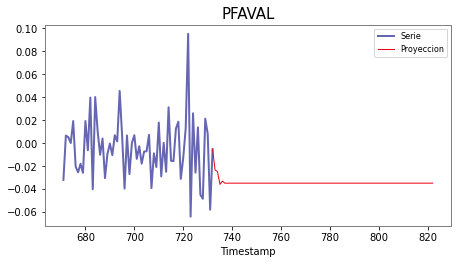

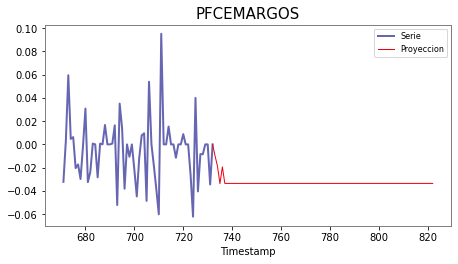

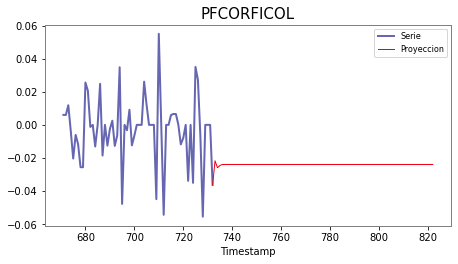

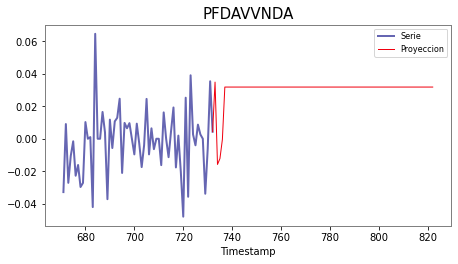

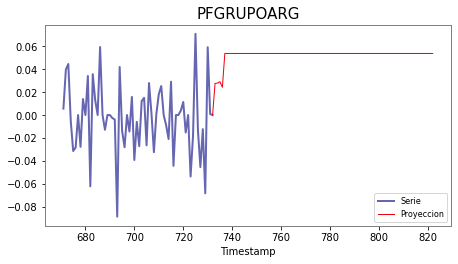

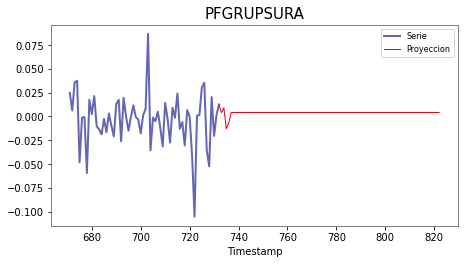

In [110]:
num_periodo_proyeccion = 90
df_pronosticos_xgb = pd.DataFrame(columns=acciones,
                                  index=range(num_periodo_proyeccion))
for i in acciones:
    df_interes = df_final[df_final['nemotecnico']==i].reset_index(drop=True)
    parmetros_optimos = result_df_xgboost[result_df_xgboost['Acción']==i].reset_index(drop=True)
    timesteps = parmetros_optimos.iloc[0,1]

    scaler = MinMaxScaler()     
    #### Train ###########
    train = df_interes.copy()[(df_interes['fecha'] < fecha_inicio_test)]    
    train = train[[variable_inte]]
    train[variable_inte] = scaler.fit_transform(pd.DataFrame(train[variable_inte].tolist()))
    train_data = train.values
    timesteps= parameters_list[j][0]
    train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
    x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]

    model =  xg.XGBRegressor(objective='reg:squarederror',n_estimators = parmetros_optimos.iloc[0,2] ,
                max_depth = parmetros_optimos.iloc[0,3], 
                min_child_weight = parmetros_optimos.iloc[0,5],
                learning_rate = parmetros_optimos.iloc[0,4],seed=1234)

    model.fit(x_train, y_train[:,0])
    ### test ###########
    test = df_interes.copy()[(df_interes['fecha'] > fecha_inicio_test)] 
    test = test[[variable_inte]] 


    #### pronostico ###########
    x_pronostico_unidos = np.empty((0,timesteps-1), int)
    y_pronostico_unidos = np.empty((0,1), int)

    pronostico = df_interes[[variable_inte]].iloc[df_interes.shape[0]-(timesteps-1):df_interes.shape[0]]
    pronostico[variable_inte] = scaler.fit_transform(pd.DataFrame(pronostico[variable_inte].tolist()))
    pronostico_data = pronostico.values 

    for m in range(num_periodo_proyeccion):
        pronostico_data_final = pronostico_data[pronostico_data.shape[0]-4:pronostico_data.shape[0]]
        x_pronostico = pronostico_data_final.T  
        y_pronostico = model.predict(x_pronostico).reshape(-1,1)
        y_pronostico = scaler.inverse_transform(y_pronostico)
        y_pronostico_unidos = np.append(y_pronostico_unidos,y_pronostico,  axis=0)
        pronostico_data = np.concatenate((pronostico_data, y_pronostico), axis=0)

    pronosticos_finales = pd.DataFrame(y_pronostico_unidos, columns =[variable_inte])
    datos_grafico = pd.concat([df_interes[[variable_inte]],pronosticos_finales],axis = 0).reset_index(drop=True)
    pronostico_timestamps = datos_grafico.index[datos_grafico.shape[0]-(num_periodo_proyeccion+1):datos_grafico.shape[0]]
    
    df_pronosticos_xgb[i] = y_pronostico_unidos
    
    plt.figure(figsize=(7.28, 3.7 ))
    plt.plot(test.index, test.values, color = '#000080', linewidth=2, alpha = 0.6)
    plt.plot(pronostico_timestamps, datos_grafico[datos_grafico.shape[0]-(num_periodo_proyeccion+1):datos_grafico.shape[0]].values, color = '#F0000F', linewidth=1)
    plt.legend(['Serie','Proyeccion'],loc=0, fontsize = 8)
    plt.xlabel('Timestamp')
    plt.title(i, fontsize = 15)
    plt.savefig(path_grafico + 'grafico_proyecciones_'+i+'.jpg',facecolor='white')
    plt.show()

# Concatenando las metricas por modelo

In [66]:
path_general='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/'
path_general

'C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/'

In [67]:
contenido = os.listdir(path_general)
print(contenido)

['.ipynb_checkpoints', '.lr_find_8c799c44-b141-4ab8-b84f-a229cef8c660.ckpt', 'Aplicaciones_ML_Tesis.ipynb', 'BCOLOMBIA_xgb.png', 'BOGOTA_xgb.png', 'BVC_xgb.png', 'CELSIA_xgb.png', 'CEMARGOS_xgb.png', 'graficos', 'images', 'items.csv', 'item_categories.csv', 'lightning_logs', 'MDT_data_tesis_new.csv', 'metricas_concatenadas.csv', 'metricas_model_RN.csv', 'metricas_model_SVR.csv', 'metricas_model_xgboost.csv', 'metricas_model_xgboost_1.csv', 'metricas_model_xgboost_RN.csv', 'modelos', 'parametro_RN.csv', 'Portafolio I.ipynb', 'Precios.xlsx', 'predicciones_xgb.xlsx', 'pronosticos', 'resultados_modelos_tesis.xlsx', 'resultados_RN.json', 'sales_train.csv', 'shops.csv', 'statquest_lstm_with_pytorch_and_lightning.ipynb', 'Teoria_Markowitz.ipynb', 'test.csv']


In [69]:
df_metrics_svr=pd.read_csv(path_general+'metricas_model_SVR.csv',sep='|')
df_metrics_xgb=pd.read_csv(path_general+'metricas_model_xgboost_1.csv',sep='|')
df_metrics_gen=pd.read_csv(path_general+'metricas_model_RN.csv',sep='|')

In [70]:
print(df_metrics_svr.shape)
df_metrics_svr.drop(columns=['Unnamed: 0','MAPE'],inplace=True)
df_metrics_svr.head()

(21, 6)


,Acción,RMSE,MAE,Modelo
0,BCOLOMBIA,0.03677,0.03037,SVR
1,BOGOTA,0.03556,0.02971,SVR
2,BVC,0.02446,0.01890,SVR
3,CELSIA,0.03678,0.03206,SVR
4,CEMARGOS,0.04485,0.03618,SVR


In [71]:
print(df_metrics_xgb.shape)
df_metrics_xgb['Modelo']='XGB'
df_metrics_xgb.drop(columns=['Unnamed: 0','MAPE'],inplace=True)
df_metrics_xgb.head()

(21, 5)


,Acción,RMSE,MAE,Modelo
0,BCOLOMBIA,0.03295,0.02610,XGB
1,BOGOTA,0.03318,0.02577,XGB
2,BVC,0.02695,0.02063,XGB
3,CELSIA,0.02279,0.01817,XGB
4,CEMARGOS,0.04839,0.03914,XGB


In [73]:
print(df_metrics_gen.shape)
#df_metrics_gen.drop(columns=['Unnamed: 0','MAPE','PARAMETROS'],inplace=True)
df_metrics_gen.drop(columns=['Unnamed: 0'],inplace=True)
df_metrics_gen=df_metrics_gen[df_metrics_gen['Modelo']=='Red Neuronal']
df_metrics_gen.rename(columns={'Serie':'Acción'}, inplace=True)
print(df_metrics_gen.shape)
df_metrics_gen.head()

(21, 5)
(21, 4)


,Acción,Modelo,RMSE,MAE
0,BCOLOMBIA,Red Neuronal,0.022516,0.013766
1,BOGOTA,Red Neuronal,0.028375,0.013494
2,BVC,Red Neuronal,0.015183,0.007718
3,CELSIA,Red Neuronal,0.013777,0.008033
4,CEMARGOS,Red Neuronal,0.022701,0.013534


In [74]:
df_metrics_final=pd.concat([df_metrics_svr,df_metrics_xgb,df_metrics_gen])
print(df_metrics_final.shape)
df_metrics_final.head()

(63, 4)


,Acción,RMSE,MAE,Modelo
0,BCOLOMBIA,0.03677,0.03037,SVR
1,BOGOTA,0.03556,0.02971,SVR
2,BVC,0.02446,0.01890,SVR
3,CELSIA,0.03678,0.03206,SVR
4,CEMARGOS,0.04485,0.03618,SVR


In [75]:
df_metrics_final.rename(columns={'Acción':'Accion'}, inplace=True)

In [76]:
df_metrics_final[df_metrics_final['Accion']=='CELSIA']

,Accion,RMSE,MAE,Modelo
3,CELSIA,0.036780,0.032060,SVR
3,CELSIA,0.022790,0.018170,XGB
3,CELSIA,0.013777,0.008033,Red Neuronal


In [83]:
pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [84]:
df_metrics_final.sort_values('Accion')

,Accion,RMSE,MAE,Modelo
0,BCOLOMBIA,0.036770,0.030370,SVR
0,BCOLOMBIA,0.032950,0.026100,XGB
0,BCOLOMBIA,0.022516,0.013766,Red Neuronal
1,BOGOTA,0.035560,0.029710,SVR
1,BOGOTA,0.033180,0.025770,XGB
1,BOGOTA,0.028375,0.013494,Red Neuronal
2,BVC,0.024460,0.018900,SVR
2,BVC,0.026950,0.020630,XGB
2,BVC,0.015183,0.007718,Red Neuronal
3,CELSIA,0.036780,0.032060,SVR


In [85]:
df_metrics_final.shape

(63, 4)

In [86]:
df_metrics_final.to_csv(path_general + 'metricas_concatenadas.csv',index=False, sep='|')

In [78]:
path_general

'C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/'

SVR             21
XGB             21
Red Neuronal    21
Name: Modelo, dtype: int64

In [79]:
df_metrics_final1=df_metrics_final[['Accion','Modelo','MAE','RMSE']]
df_metrics_final1.sort_values('MAE',ascending=True,inplace=True)

In [80]:
df_metrics_final1.drop_duplicates('Accion',keep='first',inplace=True)
print(df_metrics_final1.shape)
df_metrics_final1

(21, 4)


,Accion,Modelo,MAE,RMSE
2,BVC,Red Neuronal,0.007718,0.015183
17,PFCORFICOL,Red Neuronal,0.007937,0.015468
3,CELSIA,Red Neuronal,0.008033,0.013777
11,GRUPOAVAL,Red Neuronal,0.008863,0.020738
5,CLH,Red Neuronal,0.009002,0.023886
18,PFDAVVNDA,Red Neuronal,0.009190,0.015523
6,CNEC,Red Neuronal,0.009988,0.015970
9,EXITO,Red Neuronal,0.010177,0.021630
7,CORFICOLCF,Red Neuronal,0.010435,0.017396
16,PFCEMARGOS,Red Neuronal,0.010593,0.019274


In [89]:
df_metrics_final1.to_csv(path_general + 'metricas_concatenadas_ranking.csv',index=False, sep='|')

### Seleccionando solo entre svr y xgboost

In [90]:
df_metrics_final2=df_metrics_final[df_metrics_final['Modelo']!='Red Neuronal'][['Accion','Modelo','MAE','RMSE']]
print(df_metrics_final2.shape)
df_metrics_final2.sort_values('MAE',ascending=True,inplace=True)

(42, 4)


In [91]:
df_metrics_final2

,Accion,Modelo,MAE,RMSE
11,GRUPOAVAL,SVR,0.01374,0.01886
11,GRUPOAVAL,XGB,0.01443,0.01946
17,PFCORFICOL,SVR,0.01757,0.02404
17,PFCORFICOL,XGB,0.01769,0.02380
3,CELSIA,XGB,0.01817,0.02279
2,BVC,SVR,0.01890,0.02446
2,BVC,XGB,0.02063,0.02695
18,PFDAVVNDA,XGB,0.02072,0.02644
6,CNEC,XGB,0.02072,0.02536
7,CORFICOLCF,XGB,0.02277,0.03049


In [92]:
df_metrics_final2.drop_duplicates('Accion',keep='first',inplace=True)
print(df_metrics_final2.shape)
df_metrics_final2

(21, 4)


,Accion,Modelo,MAE,RMSE
11,GRUPOAVAL,SVR,0.01374,0.01886
17,PFCORFICOL,SVR,0.01757,0.02404
3,CELSIA,XGB,0.01817,0.02279
2,BVC,SVR,0.01890,0.02446
18,PFDAVVNDA,XGB,0.02072,0.02644
6,CNEC,XGB,0.02072,0.02536
7,CORFICOLCF,XGB,0.02277,0.03049
12,GRUPOSURA,SVR,0.02359,0.03011
20,PFGRUPSURA,XGB,0.02406,0.03385
13,ISA,XGB,0.02439,0.03154


In [93]:
df_metrics_final2.to_csv(path_general + 'metricas_concatenadas_ranking_svr_xgb.csv',index=False, sep='|')

# Nuevas Graficas

In [40]:
# import pickle

# path_model='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/modelos/PFDAVVNDA_model_xgb_1.pkl'
# with open(path_model, 'rb') as archivo:
#     model= pickle.load(archivo)

In [16]:
acciones='PFDAVVNDA'

In [17]:
df_final.head()

,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log
0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579
1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571
2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480
3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488
4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972


In [24]:
variable_inte

'variacion_log'

10PFDAVVNDA
54
54


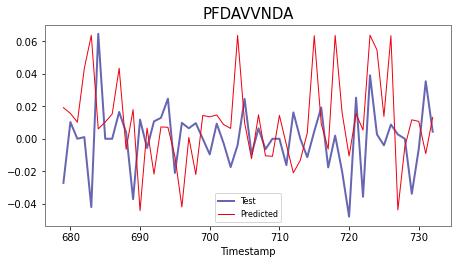

In [42]:
for i in acciones:
    
#     serie.set_index('fecha',inplace=True)
#     idx = pd.date_range(serie.index.min(), serie.index.max())
#     idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(dias_predecir,'D'))
    
    scaler = MinMaxScaler()    
    df_interes = df_final[df_final['nemotecnico']==i].reset_index()     
    #parmetros_optimos = result_df_xgboost[result_df_xgboost['Acción']==i].reset_index(drop=True)
    #timesteps = parmetros_optimos.iloc[0,1] 
    timesteps=10

    #### Train ###########
    train = df_interes.copy()[(df_interes['fecha'] < fecha_inicio_test)]    
    train = train[[variable_inte]]
    train[variable_inte] = scaler.fit_transform(pd.DataFrame(train[variable_inte].tolist()))
    train_data = train.values
    #timesteps= parameters_list[j][0]
    train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
    x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]

    #### test ###########
    test = df_interes.copy()[(df_interes['fecha'] >= fecha_inicio_test)] 
    test = test[[variable_inte]] 
    test[variable_inte] = scaler.fit_transform(pd.DataFrame(test[variable_inte].tolist()))
    test_data = test.values
    test_data_timesteps = np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
    print(str(timesteps)+ str(i))
    x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]


    model =  xg.XGBRegressor(objective='reg:squarederror',n_estimators = 100 ,
                max_depth = 15, 
                min_child_weight = 1,
                learning_rate = 0.2,seed=1234)

    model.fit(x_train, y_train[:,0])





    ### Continuando con la prediccion

    y_test_pred = model.predict(x_test).reshape(-1,1)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_test = scaler.inverse_transform(y_test)

    test_timestamps = df_interes[(df_interes['fecha'] >= fecha_inicio_test)].index[timesteps-1:]
    
    
      #graficando test vs estimacion
    
    print(len(test_timestamps))
    print(len(y_test_pred))
       
    plt.figure(figsize=(7.28, 3.7 ))
    test_data= scaler.inverse_transform(test_data)
    num_periodo_proyeccion=90
    datos_grafico = pd.concat([df_interes[[variable_inte]],predicciones],axis = 0).reset_index(drop=True)
    pronostico_timestamps = datos_grafico.index[datos_grafico.shape[0]-(num_periodo_proyeccion+1):datos_grafico.shape[0]]
    
    plt.plot(test_timestamps, test_data[-len(y_test_pred):], color = '#000080', linewidth=2, alpha = 0.6)
    plt.plot(test_timestamps, y_test_pred, color = '#F0000F', linewidth=1)
    #plt.plot(range(test.data[-1],731 + 90),result,c='m')
    plt.legend(['Test','Predicted'],loc=0, fontsize = 8)
    plt.xlabel('Timestamp')
    plt.title(i, fontsize = 15)
    plt.savefig(path_grafico + 'grafico_comparacion_prediccion_test_train_'+str(i)+'.jpg',facecolor='white')
    
    plt.show()
    


# ---------------------------------------- Hasta aqui se corre ------------------------------------------